In [16]:
import pandas_datareader.data as reader
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [65]:
# CAPM : r_i = alpha + beta_i * r_m + e
# beta = cov(r_i, r_m)/var(r_m)

end = dt.date(2024, 5, 20)
start = dt.date(end.year - 5, end.month, end.day)
inputs = ['MSFT', '^GSPC']


In [66]:
df = yf.download(inputs, start=start, end=end)
df.head()

[*********************100%%**********************]  2 of 2 completed


Price        Adj Close                    Close                     High  \
Ticker            MSFT        ^GSPC        MSFT        ^GSPC        MSFT   
Date                                                                       
2019-05-20  120.375473  2840.229980  126.220001  2840.229980  127.589996   
2019-05-21  121.023987  2864.360107  126.900002  2864.360107  127.529999   
2019-05-22  121.758324  2856.270020  127.669998  2856.270020  128.240005   
2019-05-23  120.337318  2822.239990  126.180000  2822.239990  126.290001   
2019-05-24  120.394554  2826.060059  126.239998  2826.060059  127.419998   

Price                           Low                     Open               \
Ticker            ^GSPC        MSFT        ^GSPC        MSFT        ^GSPC   
Date                                                                        
2019-05-20  2853.860107  125.760002  2831.290039  126.519997  2841.939941   
2019-05-21  2868.879883  126.580002  2854.020020  127.430000  2854.020020   
2019-05-22  2865.469971  126.519997  2851.110107  126.620003  2856.060059   
2019-05-23  2836.699951  124.739998  2805.489990  126.199997  2836.699951   
2019-05-24  2841.360107  125.970001  2820.189941  126.910004  2832.409912   

Price         Volume              
Ticker          MSFT       ^GSPC  
Date                              
2019-05-20  23706900  3293750000  
2019-05-21  15293300  3223050000  
2019-05-22  15396500  3194000000  
2019-05-23  23603800  3899320000  
2019-05-24  14123400  2889230000

In [67]:
df = df['Adj Close']
df.head()

Ticker,MSFT,^GSPC
Date,,
2019-05-20,120.375473,2840.229980
2019-05-21,121.023987,2864.360107
2019-05-22,121.758324,2856.270020
2019-05-23,120.337318,2822.239990
2019-05-24,120.394554,2826.060059


In [68]:
# As we are interested in monthly returns
mthly_returns = df.resample('M').ffill().pct_change()

In [69]:
mthly_returns.head()

Ticker,MSFT,^GSPC
Date,,
2019-05-31,NaN,NaN
2019-06-30,0.083118,0.068930
2019-07-31,0.017244,0.013128
2019-08-31,0.015037,-0.018092
2019-09-30,0.008487,0.017181


In [70]:
mthly_returns = mthly_returns.dropna(axis = 0)
mthly_returns.head()

Ticker,MSFT,^GSPC
Date,,
2019-06-30,0.083118,0.068930
2019-07-31,0.017244,0.013128
2019-08-31,0.015037,-0.018092
2019-09-30,0.008487,0.017181
2019-10-31,0.031216,0.020432


In [71]:
## Regression
X = mthly_returns["^GSPC"]
y = mthly_returns["MSFT"]
# intercept not added by default, we need to add
X_sm = sm.add_constant(X)
X_sm.head()

,const,^GSPC
Date,,
2019-06-30,1.0,0.068930
2019-07-31,1.0,0.013128
2019-08-31,1.0,-0.018092
2019-09-30,1.0,0.017181
2019-10-31,1.0,0.020432


In [72]:
model = sm.OLS(y,X_sm)


In [73]:
results = model.fit()

In [74]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     72.72
Date:                Sun, 26 May 2024   Prob (F-statistic):           8.04e-12
Time:                        15:39:30   Log-Likelihood:                 105.35
No. Observations:                  60   AIC:                            -206.7
Df Residuals:                      58   BIC:                            -202.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.006      2.170      0.034       0.001       0.024
^GSPC          0.8969      0.105      8.528      0.000       0.686       1.107
==============================================================================
Omnibus:                        4.503   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.054
Skew:                           0.637   Prob(JB):                        0.132
Kurtosis:                       3.021   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

```
	coef	std err	t	P>|t|	[0.025	0.975]
const	0.0126	0.006	2.213	0.031	0.001	0.024
^GSPC	0.9033	0.106	8.520	0.000	0.691	1.115

```

alpha is 0.0126
beta is 0.9033

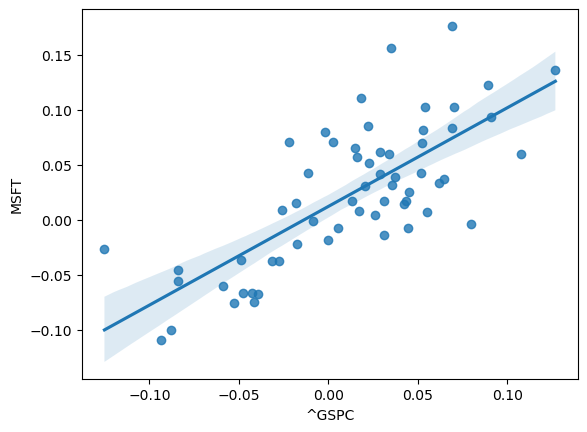

In [75]:
# Visualize results
import seaborn as sns
sns.regplot(x="^GSPC", y='MSFT', data = mthly_returns)
plt.show()

In [144]:
# BUT we forgot to take rf rate under consideration
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
rf = reader.DataReader('F-F_Research_Data_Factors', 
                       'famafrench', 
                       start = mthly_returns.index[0],
                       end = mthly_returns.index[-1]
                       )


/var/folders/mw/pvq5xc9d1klbjmpfrl8cnwfm0000gn/T/ipykernel_5866/3823817879.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = reader.DataReader('F-F_Research_Data_Factors',
/var/folders/mw/pvq5xc9d1klbjmpfrl8cnwfm0000gn/T/ipykernel_5866/3823817879.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = reader.DataReader('F-F_Research_Data_Factors',


In [145]:
mthly_returns['MSFT'].shape[0]
len(rf[0].values)


58

In [151]:
import numpy as np

rf_vals = rf[0].values
if len(rf_vals) < mthly_returns.shape[0]:
    last_n = mthly_returns.shape[0] - len(rf_vals)
    print(last_n, len(rf_vals), len(rf_vals[-last_n:]))
    rf_vals = np.append(rf_vals, rf_vals[-last_n:], axis=0)
print(len(rf_vals))

2 58 2
60


In [159]:
print(mthly_returns['MSFT'].values)
print(len(rf_vals))

[ 0.08311759  0.01724374  0.01503675  0.00848709  0.03121601  0.05946247
  0.04174926  0.07945455 -0.04568801 -0.02654162  0.1363264   0.02539113
  0.11055914  0.00737082  0.10275177 -0.06739664 -0.03736982  0.06006029
  0.03900614  0.04289177  0.00411811  0.01458818  0.06960153 -0.0076273
  0.08498879  0.05171658  0.06159099 -0.06611888  0.17629105 -0.00128214
  0.01733246 -0.07534499 -0.03721172  0.03186171 -0.09986709 -0.01807709
 -0.05532052  0.09309655 -0.06666316 -0.1092668  -0.00330601  0.10222292
 -0.06004542  0.03331661  0.0090179   0.15588158  0.06576502  0.07110551
  0.03699869 -0.01356677 -0.02222562 -0.03664287  0.07081556  0.12294541
 -0.00757439  0.05728119  0.04231836  0.01711628 -0.07461022  0.08126258]
60


In [163]:
rf_vals

array([[ 6.930e+00,  2.900e-01, -7.100e-01,  1.800e-01],
       [ 1.190e+00, -1.930e+00,  4.800e-01,  1.900e-01],
       [-2.580e+00, -2.380e+00, -4.780e+00,  1.600e-01],
       [ 1.430e+00, -9.600e-01,  6.750e+00,  1.800e-01],
       [ 2.060e+00,  2.900e-01, -1.910e+00,  1.600e-01],
       [ 3.870e+00,  7.700e-01, -2.020e+00,  1.200e-01],
       [ 2.770e+00,  7.300e-01,  1.750e+00,  1.400e-01],
       [-1.100e-01, -3.110e+00, -6.250e+00,  1.300e-01],
       [-8.130e+00,  1.070e+00, -3.810e+00,  1.200e-01],
       [-1.339e+01, -4.830e+00, -1.387e+01,  1.300e-01],
       [ 1.365e+01,  2.450e+00, -1.330e+00,  0.000e+00],
       [ 5.580e+00,  2.470e+00, -4.880e+00,  1.000e-02],
       [ 2.460e+00,  2.690e+00, -2.200e+00,  1.000e-02],
       [ 5.770e+00, -2.330e+00, -1.410e+00,  1.000e-02],
       [ 7.630e+00, -2.200e-01, -2.970e+00,  1.000e-02],
       [-3.630e+00,  2.000e-02, -2.710e+00,  1.000e-02],
       [-2.100e+00,  4.380e+00,  4.250e+00,  1.000e-02],
       [ 1.247e+01,  5.800e+00,

In [160]:
# Substract Rf rate to get excess return
# mthly_returns['MSFT-rf'] = 
mthly_returns['MSFT'].values - rf_vals


ValueError: operands could not be broadcast together with shapes (60,) (60,4) 

In [38]:
rf[0].RF.values

array([0.21, 0.18, 0.19, 0.16, 0.18, 0.16, 0.12, 0.14, 0.13, 0.12, 0.13,
       0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.01, 0.01, 0.03, 0.06, 0.08, 0.19, 0.19, 0.23, 0.29, 0.33,
       0.35, 0.34, 0.36, 0.35, 0.36, 0.4 , 0.45, 0.45, 0.43, 0.47, 0.44,
       0.43, 0.47, 0.42, 0.43])

In [39]:
mthly_returns['MSFT']

Date
2019-06-30    0.083118
2019-07-31    0.017244
2019-08-31    0.015037
2019-09-30    0.008487
2019-10-31    0.031216
2019-11-30    0.059462
2019-12-31    0.041750
2020-01-31    0.079455
2020-02-29   -0.045688
2020-03-31   -0.026542
2020-04-30    0.136326
2020-05-31    0.025391
2020-06-30    0.110559
2020-07-31    0.007370
2020-08-31    0.102752
2020-09-30   -0.067397
2020-10-31   -0.037370
2020-11-30    0.060061
2020-12-31    0.039006
2021-01-31    0.042892
2021-02-28    0.004118
2021-03-31    0.014588
2021-04-30    0.069602
2021-05-31   -0.007627
2021-06-30    0.084989
2021-07-31    0.051717
2021-08-31    0.061591
2021-09-30   -0.066119
2021-10-31    0.176291
2021-11-30   -0.001282
2021-12-31    0.017333
2022-01-31   -0.075345
2022-02-28   -0.037212
2022-03-31    0.031862
2022-04-30   -0.099867
2022-05-31   -0.018077
2022-06-30   -0.055321
2022-07-31    0.093097
2022-08-31   -0.066663
2022-09-30   -0.109267
2022-10-31   -0.003306
2022-11-30    0.102223
2022-12-31   -0.060045
2023-0

In [40]:
len(mthly_returns['MSFT'])

60

Timestamp('2024-05-31 00:00:00')